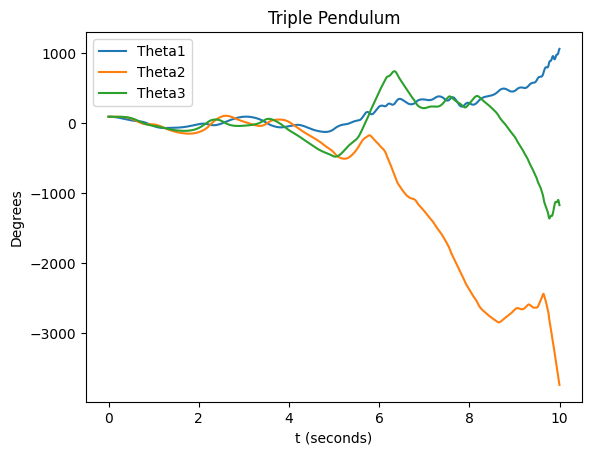

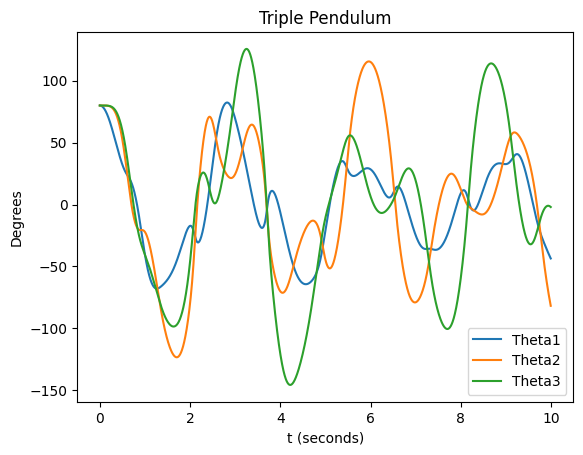

{'90_90_90': array([[0.18350776, 0.99638552, 0.69098833],
       [0.18350185, 0.99638552, 0.69098833],
       [0.18348409, 0.99638552, 0.69098833],
       ...,
       [0.99002662, 0.00862525, 0.10324351],
       [0.9961912 , 0.0041706 , 0.09621644],
       [1.        , 0.        , 0.09042012]]), '80_80_80': array([[0.98413693, 0.85107033, 0.83164651],
       [0.98409091, 0.85107033, 0.83164651],
       [0.98395284, 0.85107033, 0.83164651],
       ...,
       [0.16731653, 0.18210285, 0.53065184],
       [0.1647217 , 0.17801266, 0.53008881],
       [0.16215554, 0.17397933, 0.52947289]])}


In [2]:
from __future__ import division, print_function
from math import sin, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array

# Constants
g = 9.81  # Acceleration due to gravity
L1, L2, L3 = 1.0, 1.0, 1.0  # Lengths of pendulums
m1, m2, m3 = 1.0, 1.0, 1.0  # Masses of pendulums

def f(r, t):
    theta1, omega1, theta2, omega2, theta3, omega3 = r

    ftheta1 = omega1
    ftheta2 = omega2
    ftheta3 = omega3

    delta12 = theta1 - theta2
    delta13 = theta1 - theta3
    delta23 = theta2 - theta3

    denom1 = L1 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta13))
    denom2 = L2 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta23))
    denom3 = L3 * (2 * m1 + m2 + m3 - m3 * cos(2 * delta13))

    fomega1 = (-g * (2 * m1 + m2 + m3) * sin(theta1)
               - m2 * g * sin(theta1 - 2 * theta2)
               - m3 * g * sin(theta1 - 2 * theta3)
               - 2 * sin(delta12) * m2 * (omega2**2 * L2 + omega1**2 * L1 * cos(delta12))
               - 2 * sin(delta13) * m3 * (omega3**2 * L3 + omega1**2 * L1 * cos(delta13))) / denom1

    fomega2 = (2 * sin(delta12) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta12)
                                   + omega3**2 * L3 * m3 * cos(delta13))) / denom2

    fomega3 = (2 * sin(delta13) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta23)
                                   + omega3**2 * L3 * m3 * cos(delta13))) / denom3

    return array([ftheta1, fomega1, ftheta2, fomega2, ftheta3, fomega3], float)

# Time parameters
a, b = 0.0, 10.0
N = 2000
h = (b - a) / N
tpoints = np.arange(a, b, h)

# Initial conditions
angles = [[90, 90, 90], [80, 80, 80]]

for x in angles:
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)
    theta3_points = np.zeros_like(tpoints)

    # Initial angles (convert to radians)
    r = np.array([x[0] * pi / 180, 0, x[1] * pi / 180, 0, x[2] * pi / 180, 0], float)

    for i, t in enumerate(tpoints):
        theta1_points[i] = r[0] * 180 / pi
        theta2_points[i] = r[2] * 180 / pi
        theta3_points[i] = r[4] * 180 / pi

        # Runge-Kutta method
        k1 = h * f(r, t)
        k2 = h * f(r + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(r + k3, t + h)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    plt.plot(tpoints, theta1_points, label='Theta1')
    plt.plot(tpoints, theta2_points, label='Theta2')
    plt.plot(tpoints, theta3_points, label='Theta3')
    plt.title("Triple Pendulum")
    plt.xlabel("t (seconds)")
    plt.ylabel("Degrees")
    plt.legend()
    plt.show()


    data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
    np.save(f'triple_pendulum_data_{str(x[0])}_{str(x[1])}_{str(x[2])}.npy', data)


# Define the dataset class
class QuadraticDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)  # Shape (N, 2)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape (N, 2)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

data = {}

for i in angles:
  loaded_data = np.load(f'triple_pendulum_data_{str(i[0])}_{str(i[1])}_{str(i[2])}.npy')
  scaler = MinMaxScaler()
  data_ = scaler.fit_transform(loaded_data)
  data[f'{str(i[0])}_{str(i[1])}_{str(i[2])}'] = data_

print(data)

def create_io_triple(data):
    x, x_1, x_2, x_3, y_1, y_2, y_3 = [], [], [], [], [], [], []

    for starting in data:
        starting_theta_1_degrees = int(starting.split("_")[0])
        starting_theta_2_degrees = int(starting.split("_")[1])
        starting_theta_3_degrees = int(starting.split("_")[2])

        starting_theta_1 = starting_theta_1_degrees * pi /180
        starting_theta_2 = starting_theta_2_degrees * pi /180
        starting_theta_3 = starting_theta_3_degrees * pi /180

        angle_data = data[starting]
        for i in range(len(angle_data)):
            x.append(tpoints[i])
            x_1.append(starting_theta_1)
            x_2.append(starting_theta_2)
            x_3.append(starting_theta_3)
            y_1.append(angle_data[i][0])
            y_2.append(angle_data[i][1])
            y_3.append(angle_data[i][2])
    return x, x_1, x_2, x_3, y_1, y_2, y_3

x, x_1, x_2, x_3, y_1, y_2, y_3 = create_io_triple(data)

# Normalize data
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x_combined = np.vstack([x_1, x_2, x_3, x]).T
scaler_x = MinMaxScaler()
x_scaled = scaler_x.fit_transform(x_combined)

y_combined = np.vstack([y_1, y_2, y_3]).T
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y_combined)

# Create dataset and dataloaders
dataset = QuadraticDataset(x_scaled, y_scaled)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

Epoch 1, Train Loss: 0.06470713748713024, Test Loss: 0.04607908679172397, R^2 Score: 0.25131961703300476
Epoch 2, Train Loss: 0.04569743979955092, Test Loss: 0.04335437330882996, R^2 Score: 0.28658297657966614
Epoch 3, Train Loss: 0.041817068681120874, Test Loss: 0.038641262170858684, R^2 Score: 0.35766997933387756
Epoch 4, Train Loss: 0.03758799202623777, Test Loss: 0.035632472473662344, R^2 Score: 0.41002193093299866
Epoch 5, Train Loss: 0.035161365040403326, Test Loss: 0.0336529006017372, R^2 Score: 0.4470376968383789
Epoch 6, Train Loss: 0.03431720348453382, Test Loss: 0.03300763233564794, R^2 Score: 0.45885777473449707
Epoch 7, Train Loss: 0.03386374572874047, Test Loss: 0.03299689401173964, R^2 Score: 0.4579782485961914
Epoch 8, Train Loss: 0.033302653831196946, Test Loss: 0.03311244718497619, R^2 Score: 0.454594224691391
Epoch 9, Train Loss: 0.03299667494284222, Test Loss: 0.03158295936882496, R^2 Score: 0.4806605875492096
Epoch 10, Train Loss: 0.03251537587711937, Test Loss: 0.

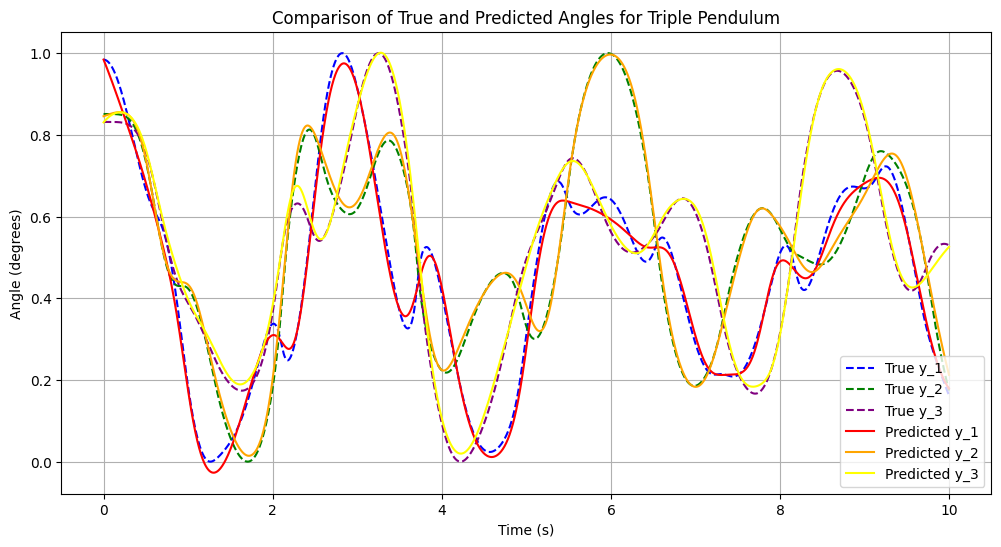

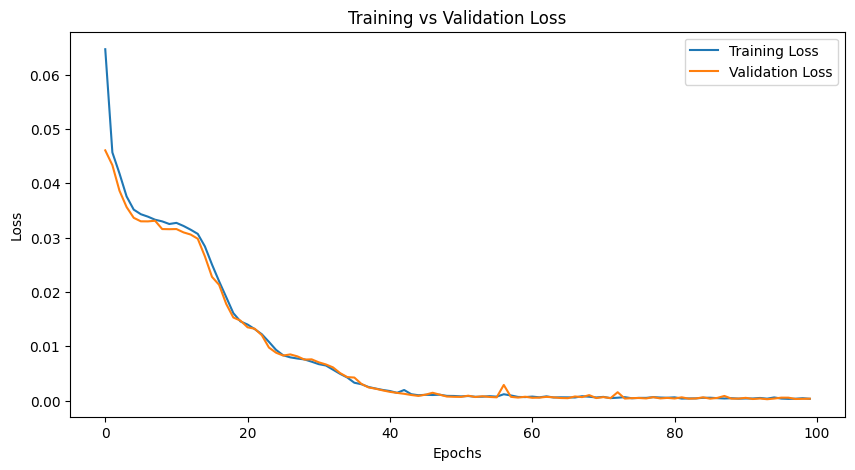

In [6]:
# check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GRU Model Definition
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.linear(gru_out[:, -1, :])
        return output

# Hyperparameters
input_size = 4  # Time + 3 angles
hidden_size = 64
output_size = 3  # Predict 3 angles
num_layers = 3
GRU_model = GRUModel(input_size, hidden_size, output_size, num_layers).to(device)

# Define loss function and optimizer
loss_function = nn.MSELoss().to(device)
optimizer = optim.Adam(GRU_model.parameters(), lr=0.001)

early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

# Training function with early stopping
def train_model(model, train_loader, test_loader, num_epochs):
    best_loss = float('inf')
    patience_counter = 0
    best_model = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            sequences = sequences.unsqueeze(1)  # Add sequence dimension
            optimizer.zero_grad()
            y_pred = model(sequences)
            loss = loss_function(y_pred, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for sequences, targets in test_loader:
                sequences, targets = sequences.to(device), targets.to(device)
                sequences = sequences.unsqueeze(1)  # Add sequence dimension
                y_pred = model(sequences)
                loss = loss_function(y_pred, targets)
                test_loss += loss.item()
                all_preds.append(y_pred.cpu())
                all_targets.append(targets.cpu())

        test_loss /= len(test_loader)
        val_losses.append(test_loss)

        all_preds = torch.cat(all_preds).numpy()
        all_targets = torch.cat(all_targets).numpy()

        r2 = r2_score(all_targets, all_preds, multioutput='uniform_average')
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}, R^2 Score: {r2}')

        if test_loss < best_loss:
            best_loss = test_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping")
            break

    if best_model:
        model.load_state_dict(best_model)
        torch.save(GRU_model.state_dict(), 'lstm_model.pth')

    return train_losses, val_losses

# Training the model
NUM_EPOCHS = 100
train_losses, val_losses = train_model(GRU_model, train_loader, test_loader, NUM_EPOCHS)

# Generate predictions for 120,2
x_dense_combined = np.vstack([x_1[2000:4000], x_2[2000:4000], x_3[2000:4000], x[2000:4000]]).T
x_dense_scaled = scaler_x.transform(x_dense_combined)
x_dense_tensor = torch.tensor(x_dense_scaled, dtype=torch.float32).unsqueeze(1).to(device)

GRU_model.eval()
with torch.no_grad():
    y_pred_scaled = GRU_model(x_dense_tensor).cpu().numpy()



# Inverse transform predictions
y_pred_90_90 = scaler_y.inverse_transform(y_pred_scaled)

# RMSE and R^2 scores
rmse = np.sqrt(mean_squared_error(y_combined[2000:4000], y_pred_90_90))
r2 = r2_score(y_combined[2000:4000], y_pred_90_90)
print(f"Final RMSE: {rmse}")
print(f"Final R^2 Score: {r2}")

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(x[2000:4000], y_1[2000:4000], label='True y_1', color='blue', linestyle='--')
plt.plot(x[2000:4000], y_2[2000:4000], label='True y_2', color='green', linestyle='--')
plt.plot(x[2000:4000], y_3[2000:4000], label='True y_3', color='purple', linestyle='--')
plt.plot(x[2000:4000], y_pred_90_90[:, 0], label='Predicted y_1', color='red')
plt.plot(x[2000:4000], y_pred_90_90[:, 1], label='Predicted y_2', color='orange')
plt.plot(x[2000:4000], y_pred_90_90[:, 2], label='Predicted y_3', color='yellow')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.title('Comparison of True and Predicted Angles for Triple Pendulum')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()